# **기계학습 - 중간고사 대체 과제**

**<div style="text-align: right"> 202021497 이주철 </div>**

## **지도학습을 이용한 분류 모델 구현 및 분석**

### **과제 목적:**

- A. 실제 분류 데이터를 활용해 머신러닝 모델을 설계하고 평가하는 경험을 갖는다.
- B. 분류 모델의 성능을 다양한 지표로 평가하고, 최적의 하이퍼파라미터를 찾아본다.
- C. scikit-learn 의 분류 모델 활용 능력과 데이터 전처리 이해도를 종합적으로
평가한다.

### **데이터셋:**

- 버섯의 독성 여부 데이터셋:
    - 버섯 분류 데이터셋으로 각 버섯의 형태, 식용가능인지와 독성 여부 등 22개의 범주형 특성을 포함하고 있습니다. 
    - 타겟 변수는 Mushroom_quality 이고 e(식용가능)와 p(독성있음)로 이진 분류를 통해 판단합니다.

### **과제:**

- 모델 구현:
    - Logistic Regression - 두 데이터 관계를 사용하여 다른 요인을 기반으로 특정 범주에 속할 확률을 0에서 1 사이의 값으로 예측합니다. 예측한 확률 형태를 비선형 결과로 변환하기 때문에 분류하는데 효율이 높습니다.
    - RandomForestClassifier - 여러 개의 결정트리를 학습시킨 후, 다수결 혹은 확률 평균으로 최종 분류를 수행하는 앙상블 모델입니다.
- 성능 평가 및 시각화:
    - 훈련된 Logistic Regression, RandomForestClassifier 모델을 활용하여 버섯의 독성 여부를 예측하여 평가합니다.
    - Accuracy, Precision / Recall / F1-score, Confusion Matrix를 모두 사용하여 평가 지표를 나타낸다. 
    - 라이브러리를 활용하여 결과를 시각화하세요.
- 최적 모델 선정 및 결과 분석:
    - GridSearchCV 또는 RandomizedSearchCV 사용하여 시스템의 정확도와 성능을 분석합니다.
    - 모델의 한계와 고려할 점을 분석합니다.

---

과제를 시작하기 전, 과제에 필요한 모듈을 다운로드합니다.

In [99]:
%pip install datasets

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## **1) 데이터셋 불러오기**

---

과제를 진행하기 위한 디렉토리 구조는 아래와 같습니다.

```
├── data
│   └── Mushroom_data.csv
├── main.ipynb
```

In [100]:
import pandas as pd

# 데이터 불러오기
df = pd.read_csv('data/Mushroom_data.csv')

# 기본 정보 확인
print(df.describe())
print(df.head())

       Mushroom_quality cap_shape cap_surface cap_color bruises  odor  \
count              8124      8124        8124      8124    8124  8124   
unique                2         6           4        10       2     9   
top                   e         x           y         n       f     n   
freq               4208      3656        3244      2284    4748  3528   

       gill_attachment gill_spacing gill_size gill_color  ...  \
count             8124         8124      8124       8124  ...   
unique               2            2         2         12  ...   
top                  f            c         b          b  ...   
freq              7914         6812      5612       1728  ...   

       stalk_surface_below_ring stalk_color_above_ring stalk_color_below_ring  \
count                      8124                   8124                   8124   
unique                        4                      9                      9   
top                           s                      w           

## **2) 결측치 확인 및 처리**

---  

NaN은 없었지만 데이터 파일을 확인하던 중 'stalk_root' 컬럼에 '?' 값이 있는 것을 발견하여 이 문자를 결측치로 판단하였습니다. 

In [101]:
# 결측치 개수 확인
print(f"nan 개수: {df.isnull().sum().sum()}")
# 데이터셋에서 '?'열 값을 발견하여 위 문자 개수를 파악하였습니다. 
print(f"? 개수: {(df == '?').sum().sum()}")

nan 개수: 0
? 개수: 2480


In [102]:
# '?'를 nan 으로 채운 후 데이터 분류를 하였습니다. 
df_cleaned = df.replace('?', pd.NA)

# 결측치가 있는 컬럼만 출력
nan_counts = df.isna().sum()
columns_with_nan = nan_counts[nan_counts > 0]
print(f"nan 개수:\n{columns_with_nan}")

nan 개수:
Series([], dtype: int64)


In [103]:
# 결측치 처리를 최빈값으로 대체하였습니다.
for col in columns_with_nan.index:
    mode_value = df[col].mode()[0] 
    df[col] = df[col].fillna(mode_value)  

# 결측치가 있는 컬럼만 출력
nan_counts = df.isna().sum()
columns_with_nan = nan_counts[nan_counts > 0]
print(f"nan 개수:\n{columns_with_nan}")

nan 개수:
Series([], dtype: int64)


## **3) 범주형 변수 인코딩**

---  

1. 명목형, 서열형 분리
2. 정수형으로 인코딩
3. 명목형은 OneHotEncoding
4. 서열형은 StandardScaling

명목형과 서열형을 분리한 후 이 두 범주형을 알맞은 방법으로 인코딩을 진행합니다.<br/>
label encoder를 사용해서 명목형을 숫자로 바꿔주고, 서열형은 순서에 대한 매핑을 통해 좁음, 넓음 혹은 하나, 둘 이런식으로 순서가 있는 숫자로 바꾸어 주었습니다. 

In [104]:
# 범주형 컬럼 분류

# Nominal(명목형) 컬럼 리스트
nominal_columns = [
    'Mushroom_quality', 'cap_shape', 'cap_surface', 'cap_color', 'bruises', 
    'odor', 'gill_attachment', 'gill_color', 'stalkshape', 'stalk_root',
    'stalk_surface_above_ring', 'stalk_surface_below_ring',
    'stalk_color_above_ring', 'stalk_color_below_ring', 'veil_type',
    'veil_color', 'ring_type', 'spore_print_color', 'habitat'
]

# Ordinal(서열형) 컬럼 리스트
ordinal_columns = ['gill_spacing', 'gill_size', 'ring_number', 'population']

In [105]:
from sklearn.preprocessing import LabelEncoder

# 인코딩용 df 새로 생성
df_encoded = df.copy()

# 명목형 변수 인코딩
le = LabelEncoder()
for col in nominal_columns:
    if col in df_encoded.columns:  # 컬럼 이름 확인
        df_encoded[f'{col}'] = le.fit_transform(df_encoded[col])
        # 인코딩 매핑 정보 저장 (옵션)
        mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        print(f"{col} 인코딩 매핑: {mapping}")

Mushroom_quality 인코딩 매핑: {'e': np.int64(0), 'p': np.int64(1)}
cap_shape 인코딩 매핑: {'b': np.int64(0), 'c': np.int64(1), 'f': np.int64(2), 'k': np.int64(3), 's': np.int64(4), 'x': np.int64(5)}
cap_surface 인코딩 매핑: {'f': np.int64(0), 'g': np.int64(1), 's': np.int64(2), 'y': np.int64(3)}
cap_color 인코딩 매핑: {'b': np.int64(0), 'c': np.int64(1), 'e': np.int64(2), 'g': np.int64(3), 'n': np.int64(4), 'p': np.int64(5), 'r': np.int64(6), 'u': np.int64(7), 'w': np.int64(8), 'y': np.int64(9)}
bruises 인코딩 매핑: {'f': np.int64(0), 't': np.int64(1)}
odor 인코딩 매핑: {'a': np.int64(0), 'c': np.int64(1), 'f': np.int64(2), 'l': np.int64(3), 'm': np.int64(4), 'n': np.int64(5), 'p': np.int64(6), 's': np.int64(7), 'y': np.int64(8)}
gill_attachment 인코딩 매핑: {'a': np.int64(0), 'f': np.int64(1)}
gill_color 인코딩 매핑: {'b': np.int64(0), 'e': np.int64(1), 'g': np.int64(2), 'h': np.int64(3), 'k': np.int64(4), 'n': np.int64(5), 'o': np.int64(6), 'p': np.int64(7), 'r': np.int64(8), 'u': np.int64(9), 'w': np.int64(10), 'y': np.in

In [106]:
# 서열형(ordinal) 컬럼의 고유값 확인
for col in ordinal_columns:
    print(f'{col} uniqu 값: {df_encoded[col].unique()}')

gill_spacing uniqu 값: ['c' 'w']
gill_size uniqu 값: ['n' 'b']
ring_number uniqu 값: ['o' 't' 'n']
population uniqu 값: ['s' 'n' 'a' 'v' 'y' 'c']


In [107]:
# 서열형 변수 인코딩
# 각 서열형 변수에 대한 순서 매핑 정의
gill_spacing_order = {'c': 1, 'w': 2}  # 좁음(close) -> 넓음(wide)
gill_size_order = {'n': 1, 'b': 2}     # 좁음(narrow) -> 넓음(broad)
ring_number_order = {'n': 0, 'o': 1, 't': 2}  # 없음(none) -> 하나(one) -> 둘(two)
population_order = {'v': 1, 'y': 2, 's': 3, 'n': 4, 'a': 5, 'c': 6}  # 희귀 -> 풍부 순서

In [108]:
# 서열형 변수별 매핑 적용
if 'gill_spacing' in df_encoded.columns:
    df_encoded['gill_spacing'] = df_encoded['gill_spacing'].map(gill_spacing_order)
if 'gill_size' in df_encoded.columns:
    df_encoded['gill_size'] = df_encoded['gill_size'].map(gill_size_order)
if 'ring_number' in df_encoded.columns:
    df_encoded['ring_number'] = df['ring_number'].map(ring_number_order)
if 'population' in df_encoded.columns:
    df_encoded['population'] = df_encoded['population'].map(population_order)

In [109]:
# 명목형 컬럼에서 타겟 제거
if 'Mushroom_quality' in nominal_columns:
    nominal_columns.remove('Mushroom_quality')

### 파이프 라인 구현
---

onehotencoder와 standardscaler를 활용하여 명목형과 서열형을 인코딩하고 모델을 학습할 수 있게 파이프 라인을 구현합니다. 

In [110]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# 타겟 변수 분리
X = df_encoded.drop(columns=['Mushroom_quality'])
y = df_encoded['Mushroom_quality']

# 전처리 파이프라인
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), nominal_columns),  # 명목형
        ('scale', StandardScaler(), ordinal_columns)                                                # 서열형
    ]
)
print(X.columns.tolist())

['cap_shape', 'cap_surface', 'cap_color', 'bruises', 'odor', 'gill_attachment', 'gill_spacing', 'gill_size', 'gill_color', 'stalkshape', 'stalk_root', 'stalk_surface_above_ring', 'stalk_surface_below_ring', 'stalk_color_above_ring', 'stalk_color_below_ring', 'veil_type', 'veil_color', 'ring_number', 'ring_type', 'spore_print_color', 'population', 'habitat']


In [111]:
# X 파이프라인 적용
X_processed = preprocessor.fit_transform(X)

# 확인
print(f"최종 전처리된 X shape: {X_processed.shape}")

최종 전처리된 X shape: (8124, 108)


## **4) 분석 전 EDA 시각화**

---  

1. Spearman 상관계수 계산 
2. 히트맵 시각화 코드

서열형 변수와 타겟 간 관계를 시각화 하여 독성 여부에 영향을 끼치는 상관관계를 확인합니다. 



타겟이 얼마나 분포되어 있는지 countplot으로 시각화합니다. 

C:\Users\jclle\AppData\Local\Temp\ipykernel_16540\3041754224.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Mushroom_quality', palette='Set2')


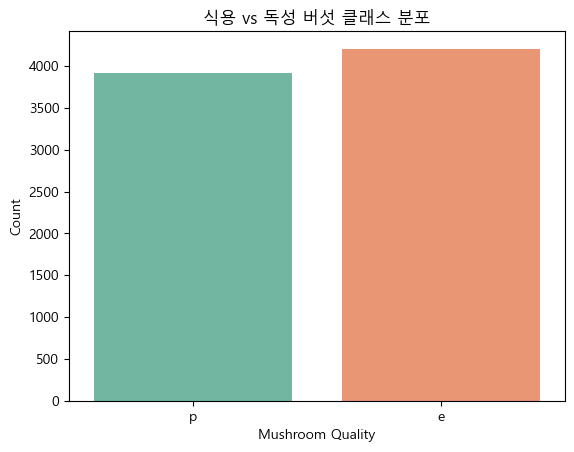

In [112]:
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

sns.countplot(data=df, x='Mushroom_quality', palette='Set2')
plt.title('식용 vs 독성 버섯 클래스 분포')
plt.xlabel('Mushroom Quality')
plt.ylabel('Count')
plt.show()


서열형 변수와 타켓이 어떤 상관관계가 있는지 시각화를 통해 분석을 합니다. 

In [113]:
# 서열형과 타겟간의 상관계수를 계산합니다. p-value는 평균이고 스케일링을 적용하여 0으로 판단됩니다. 
corr_values = []
print("타겟 변수와 서열형 변수 간의 Spearman 상관계수")
for feature in ordinal_columns:
    corr, pval = spearmanr(df['Mushroom_quality'], df[feature])
    print(f"- {feature}: 상관계수 = {corr:.3f}, p-value = {pval:.4f}")
    corr_values.append((feature, corr))

타겟 변수와 서열형 변수 간의 Spearman 상관계수
- gill_spacing: 상관계수 = -0.348, p-value = 0.0000
- gill_size: 상관계수 = 0.540, p-value = 0.0000
- ring_number: 상관계수 = -0.214, p-value = 0.0000
- population: 상관계수 = 0.224, p-value = 0.0000


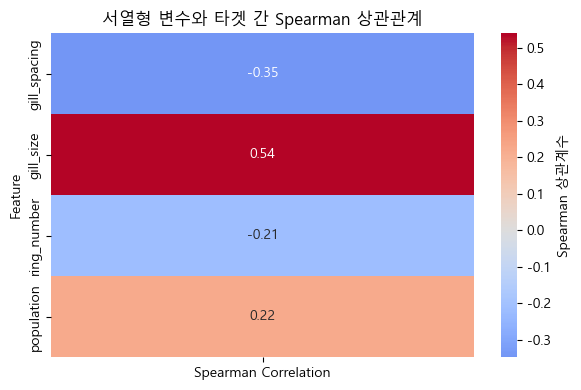

In [114]:
# 데이터프레임 변환
corr_df = pd.DataFrame(corr_values, columns=["Feature", "Spearman Correlation"])
corr_df.set_index("Feature", inplace=True)

# Spearman 히트맵 시각화
plt.figure(figsize=(6, 4))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', center=0, cbar_kws={'label': 'Spearman 상관계수'})
plt.title('서열형 변수와 타겟 간 Spearman 상관관계')
plt.tight_layout()
plt.show()

1. gill_spacing: 상관계수 = -0.348
- 주름 간격이 넓을수록 독버섯일 가능성 낮음
- 반대로 말하면, 주름이 좁을수록 독버섯일 가능성 높음

2. gill_size: 상관계수 = 0.540
- 상관계수가 가장 큼
- 주름 크기가 좁을수록 독버섯 가능성이 낮아짐
- 즉, **넓을 주름(narrow)** 일수록 독버섯에 많이 등장

3. ring_number: 상관계수 = -0.214
- 버섯 고리 개수가 많을수록 (none < one < two) 식용일 가능성이 약간 증가
- 하지만 상관계수는 비교적 낮으므로 약한 관계

4. population: 상관계수 = -0.477
- 많이 발견되는 개체일수록(풍부할수록) 식용 가능성이 높음

즉, 희귀한 버섯일수록 독버섯일 확률이 높다고 판단할 수 있습니다. 

### 명목형 컬럼과 타겟 컬럼 관계 시각화 

---

명목형 변수와 타겟 간 관계를 시각화 하여 독성과의 관계를 보여줍니다. 

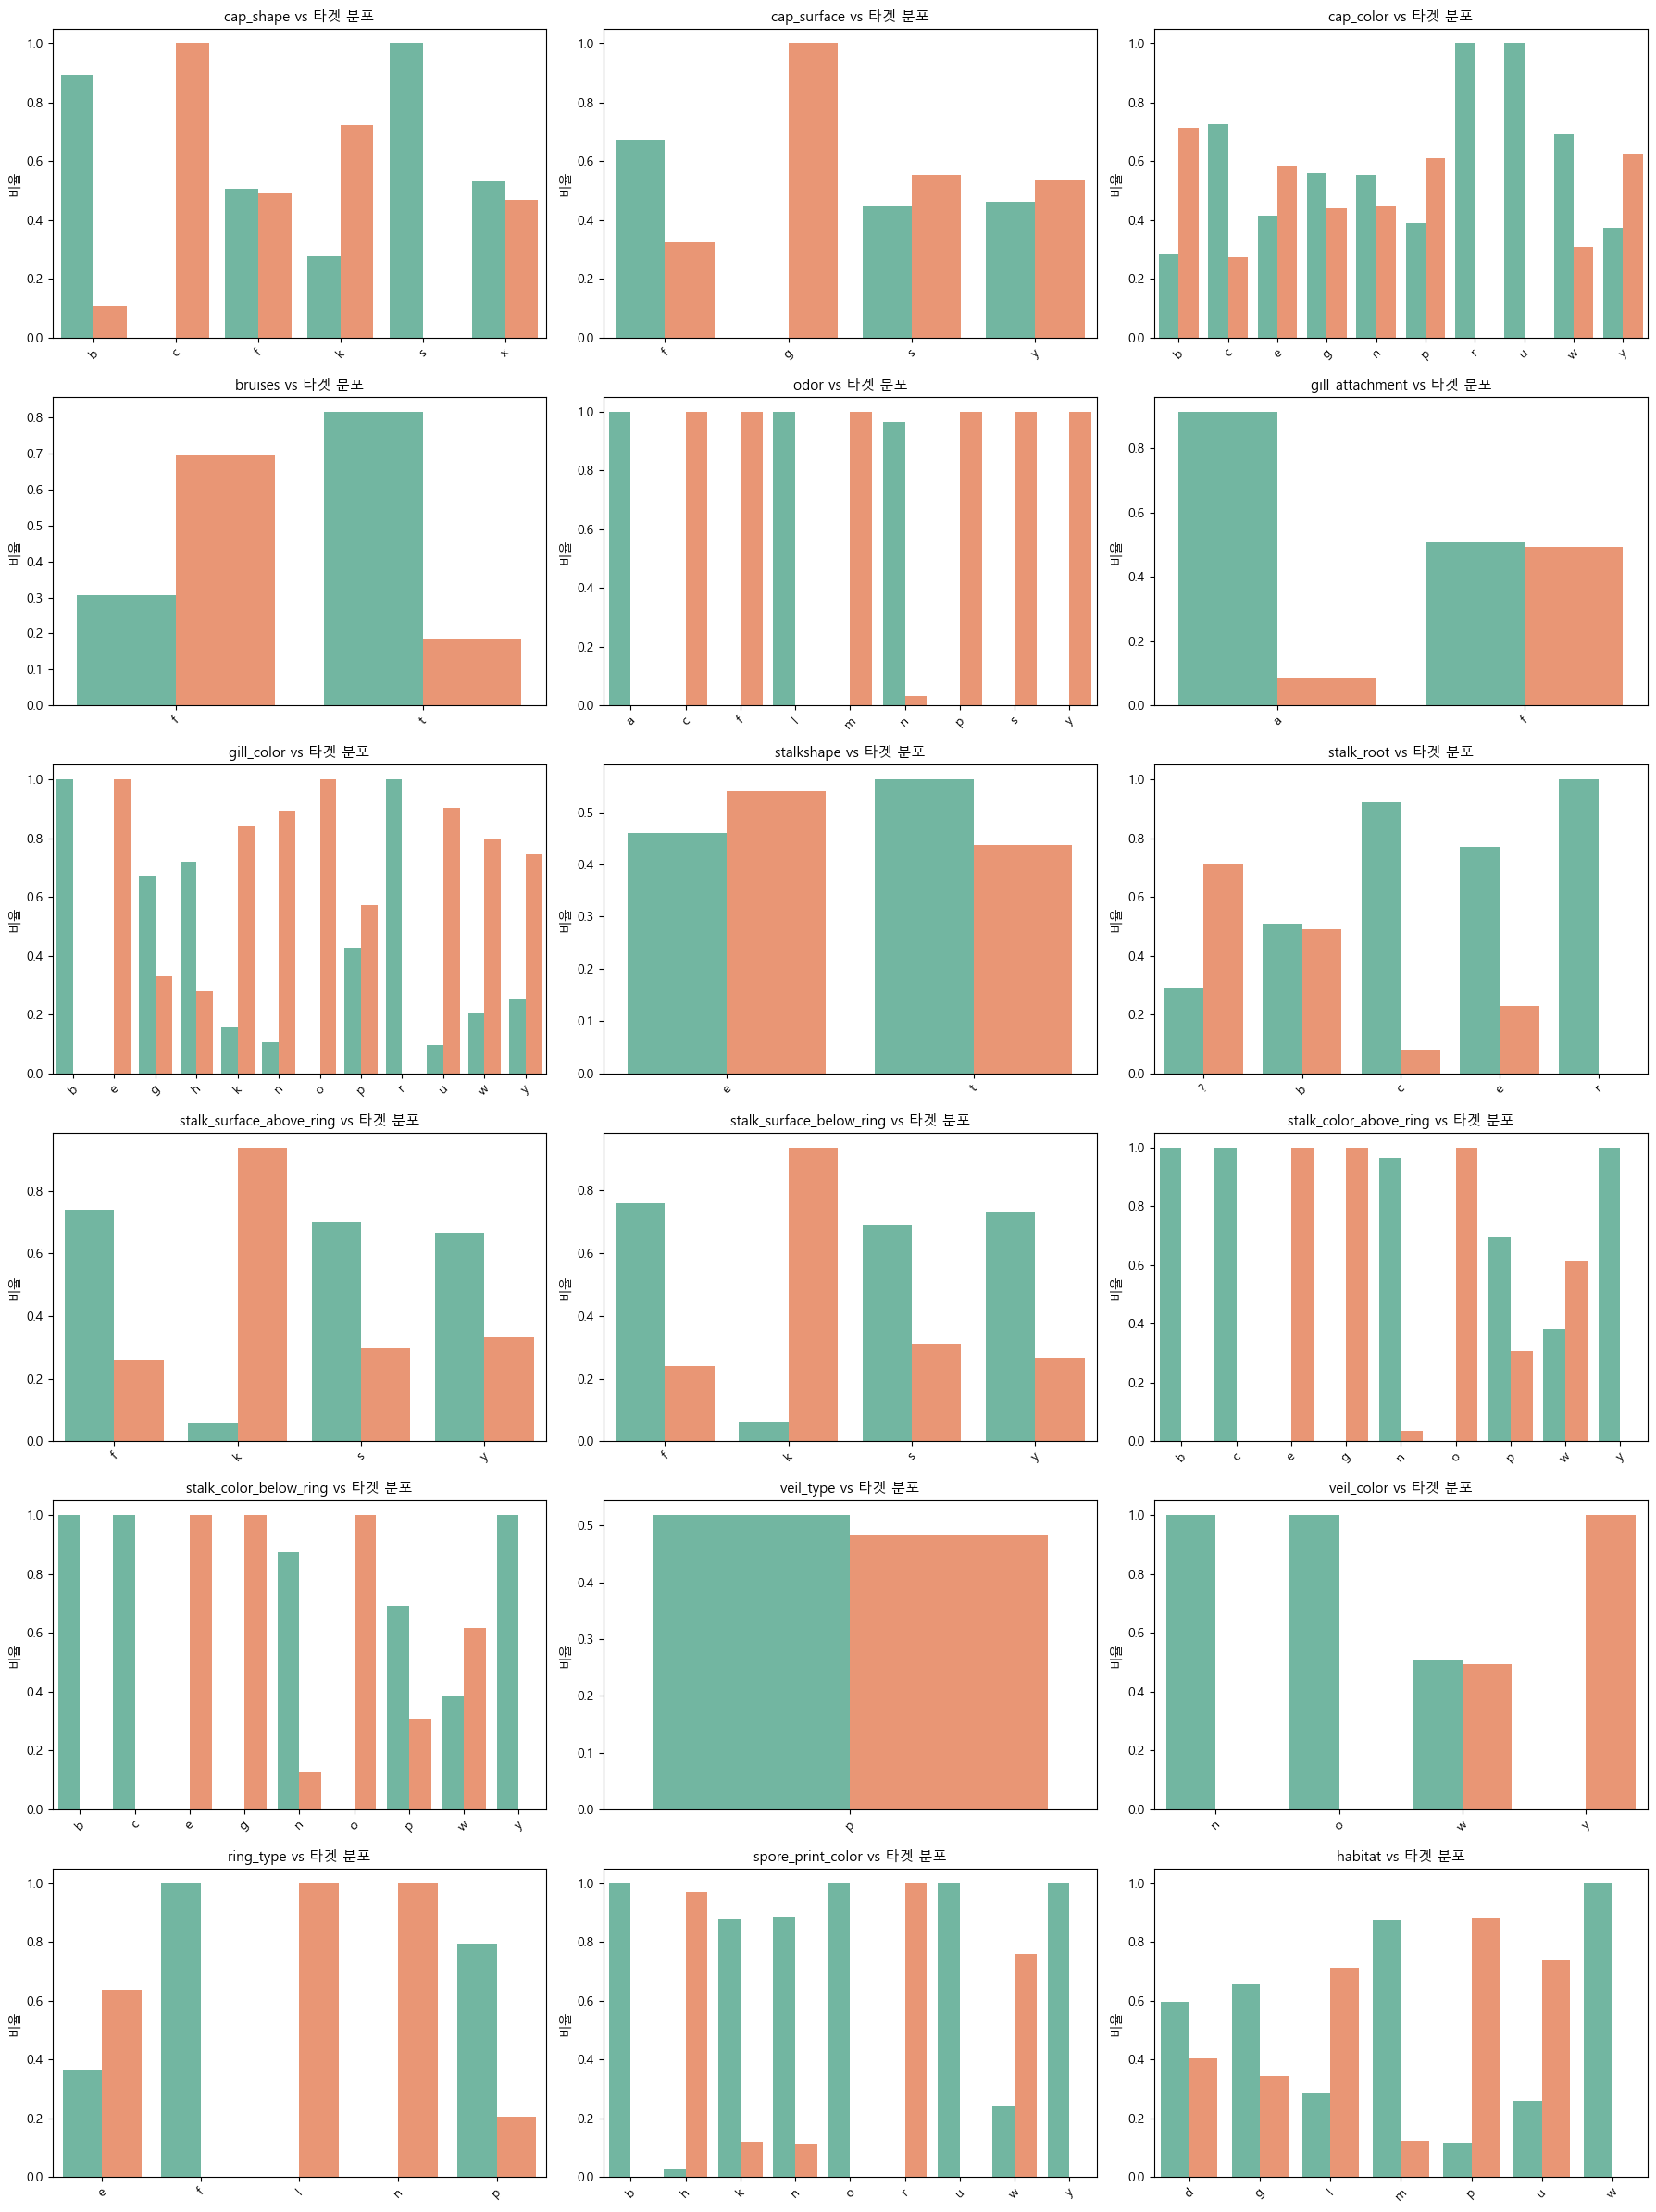

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
import matplotlib.font_manager as fm

# subplot 레이아웃 계산
n_cols = 3
n_rows = math.ceil(len(nominal_columns) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(nominal_columns):
    ax = axes[i]
    
    try:
        # 그룹화 및 비율 계산
        data = df.groupby([col, 'Mushroom_quality']).size().reset_index(name='count')
        total = data.groupby(col)['count'].transform('sum')
        data['ratio'] = data['count'] / total

        bar = sns.barplot(data=data, x=col, y='ratio', hue='Mushroom_quality', palette='Set2', ax=ax)
        bar.set_title(f'{col} vs 타겟 분포', fontsize=11)
        bar.set_ylabel('비율')
        bar.set_xlabel('')
        bar.tick_params(axis='x', labelrotation=45) 

        if bar.get_legend():
            bar.get_legend().remove()
    except Exception as e:
        ax.set_visible(False)
        print(f"- {col} 처리 중 에러 발생: {e}")

# 빈 subplot 숨기기
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


## **5) 타겟 설정 및 학습 데이터 분리**
---

- x, y에 입력 변수와 예측할 컬럼들을 설정하여 피처로 사용하고 train과 test로 분리하여 학습과 예측을 진행합니다.
-  Random Forest Classifier, Logistic Regression를 활용하여 분류합니다.

In [116]:
print(f"학습에 필요한 컬럼: {X.columns}")
print(f"타겟 컬럼: {y}")

학습에 필요한 컬럼: Index(['cap_shape', 'cap_surface', 'cap_color', 'bruises', 'odor',
       'gill_attachment', 'gill_spacing', 'gill_size', 'gill_color',
       'stalkshape', 'stalk_root', 'stalk_surface_above_ring',
       'stalk_surface_below_ring', 'stalk_color_above_ring',
       'stalk_color_below_ring', 'veil_type', 'veil_color', 'ring_number',
       'ring_type', 'spore_print_color', 'population', 'habitat'],
      dtype='object')
타겟 컬럼: 0       1
1       0
2       0
3       1
4       0
       ..
8119    0
8120    0
8121    0
8122    1
8123    0
Name: Mushroom_quality, Length: 8124, dtype: int64


### **학습 데이터 분리**
---

train data, test data로 분할하여 모델을 학습 시키는데 활용할 것입니다. 
<br/>

Random Forest Classifier로 분류합니다. 

In [117]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    ConfusionMatrixDisplay, roc_auc_score
)

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.3, random_state=42, stratify=y
)

# 1. 모델 정의 및 학습
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# 2. RandomForestClassifier 예측
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# Accuracy, Precision, Recall, F1-score, Confusion Matrix를 사용하여 성능 평가를 합니다.
# RandomForest 평가
rf_accuracy = accuracy_score(y_test, y_test_pred_rf)
rf_report = classification_report(y_test, y_test_pred_rf)
rf_conf_matrix = confusion_matrix(y_test, y_test_pred_rf)
rf_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])

Logistic Regression으로 분류합니다. 

In [118]:
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.3, random_state=42, stratify=y
)

# 1. 모델 정의 및 학습
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

# 2. LogisticRegression 예측
y_train_pred_lr = lr_model.predict(X_train)
y_test_pred_lr = lr_model.predict(X_test)

# Accuracy, Precision, Recall, F1-score, Confusion Matrix를 사용하여 성능 평가를 합니다.
# LogisticRegression 평가
lr_accuracy = accuracy_score(y_test, y_test_pred_lr)
lr_report = classification_report(y_test, y_test_pred_lr)
lr_conf_matrix = confusion_matrix(y_test, y_test_pred_lr)
lr_auc = roc_auc_score(y_test, lr_model.predict_proba(X_test)[:, 1])

### **성능 평가**
---

-  Accuracy, Precision / Recall / F1-score, Confusion Matrix, ROC Curve & AUC (이진 분류일 경우) 위 4가지 성능 지표를 통해 모델 정확도를 평가합니다. (예: odor = foul이면 대부분 독버섯) <br/>
예시로 odor, spore_print_color 두 개의 컬럼으로 분류도 진행해 보았습니다.
- 정확도가 거의 100%가 나오는 이유도 평가합니다. 

In [119]:
# RandomForest 성능 출력
print("\nTest Set 성능 (Random Forest)")
print(f"- Accuracy: {rf_accuracy:.4f}")
print(f"- ROC AUC: {rf_auc:.4f}")

print("\nConfusion Matrix:")
print(rf_conf_matrix)

print("\nPrecision / Recall / F1-score Report:")
print(rf_report)

print(f"\nROC AUC Score (Test Set): {rf_auc:.4f}")


Test Set 성능 (Random Forest)
- Accuracy: 1.0000
- ROC AUC: 1.0000

Confusion Matrix:
[[1263    0]
 [   0 1175]]

Precision / Recall / F1-score Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1263
           1       1.00      1.00      1.00      1175

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438


ROC AUC Score (Test Set): 1.0000


정확도와 정밀도를 예측하여 몇개가 잘 예측하였고, 몇개가 잘못 예측하였는지 시각화를 통해 확인합니다. 

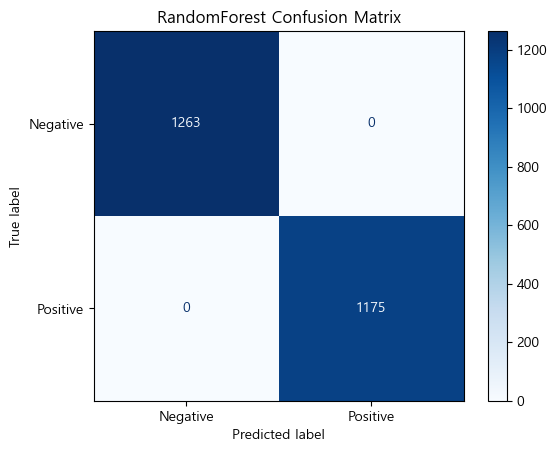

In [120]:
# RandomForest Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, y_test_pred_rf, 
    cmap='Blues', 
    display_labels=['Negative', 'Positive']
)
plt.title('RandomForest Confusion Matrix')
plt.show()

In [121]:
# LogisticRegression 성능 출력
print("\nTest Set 성능 (Logistic Regression)")
print(f"- Accuracy: {lr_accuracy:.4f}")
print(f"- ROC AUC: {lr_auc:.4f}")
print(lr_report)

print("Confusion Matrix (Test Set):")
print(lr_conf_matrix)

print("\nPrecision / Recall / F1-score Report:")
print(lr_report)

print(f"\nROC AUC Score (Test Set): {lr_auc:.4f}")


Test Set 성능 (Logistic Regression)
- Accuracy: 1.0000
- ROC AUC: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1263
           1       1.00      1.00      1.00      1175

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438

Confusion Matrix (Test Set):
[[1263    0]
 [   0 1175]]

Precision / Recall / F1-score Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1263
           1       1.00      1.00      1.00      1175

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438


ROC AUC Score (Test Set): 1.0000


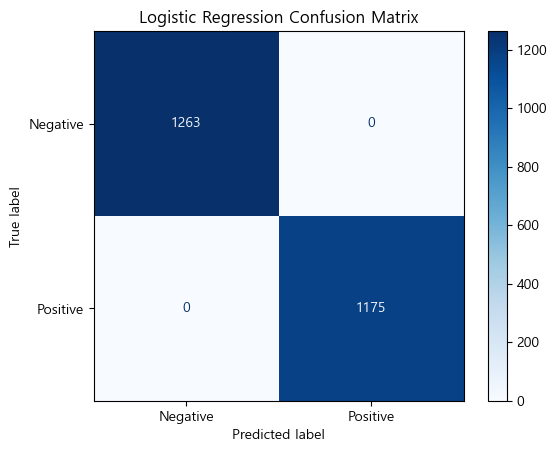

In [122]:
# LogisticRegression Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, y_test_pred_lr, 
    cmap='Blues', 
    display_labels=['Negative', 'Positive']
)
plt.title('Logistic Regression Confusion Matrix')
plt.show()

x축에서 flase posive가 0일경우 true posive는 100을 나타냅니다. 이는 정확도가 1로 가까워 높다고 평가합니다. 

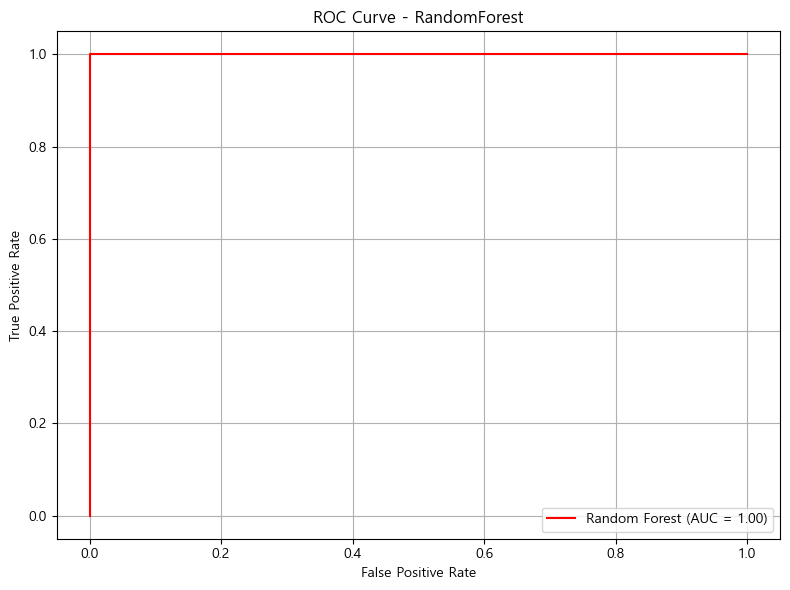

In [123]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_model.predict_proba(X_test)[:, 1])

# ROC Curve 시각화
plt.figure(figsize=(8, 6))

# RandomForest
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC = {rf_auc:.2f})",color= 'red')

plt.title('ROC Curve - RandomForest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


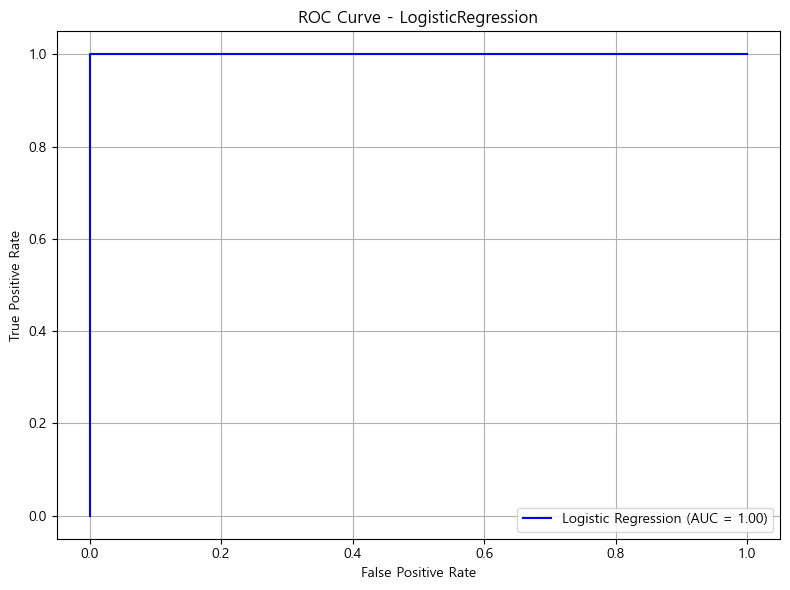

In [124]:
# ROC Curve 시각화
plt.figure(figsize=(8, 6))

# LogisticRegression
plt.plot(lr_fpr, lr_tpr, label=f"Logistic Regression (AUC = {lr_auc:.2f})",color= 'blue')

plt.title('ROC Curve - LogisticRegression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

불균형 데이터를 평가하기 위해 정밀도와 재현율의 관계를 평가합니다. x축은 실제 positive중 정확히 예측한 비율이고, y축은 positive로 예측할 경우에 실제 positive의 비율을 말합니다. 

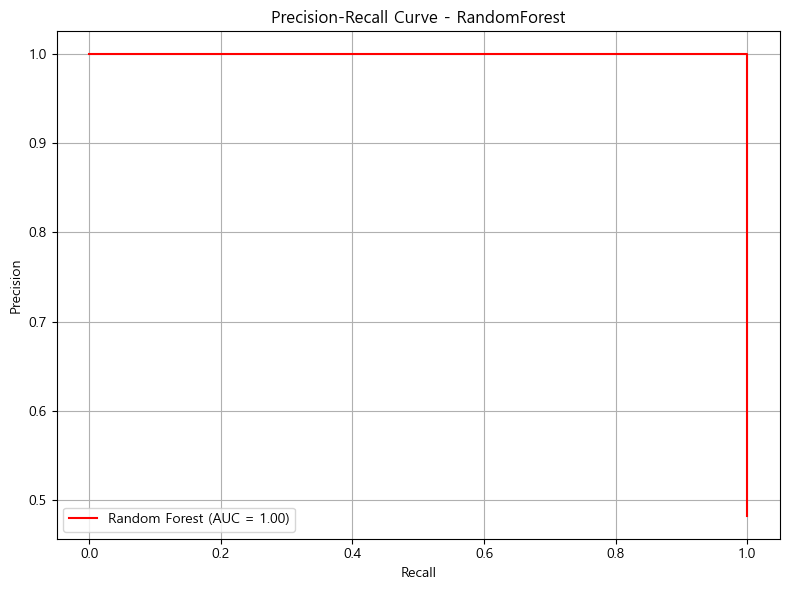

In [125]:
# Precision-Recall Curve 계산
rf_precision, rf_recall, _ = precision_recall_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_model.predict_proba(X_test)[:, 1])

# PRC-AUC 계산 (optional)
rf_prc_auc = auc(rf_recall, rf_precision)
lr_prc_auc = auc(lr_recall, lr_precision)

# Precision-Recall Curve 시각화
plt.figure(figsize=(8, 6))

# RandomForest
plt.plot(rf_recall, rf_precision, label=f"Random Forest (AUC = {rf_prc_auc:.2f})",color='red')

plt.title('Precision-Recall Curve - RandomForest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


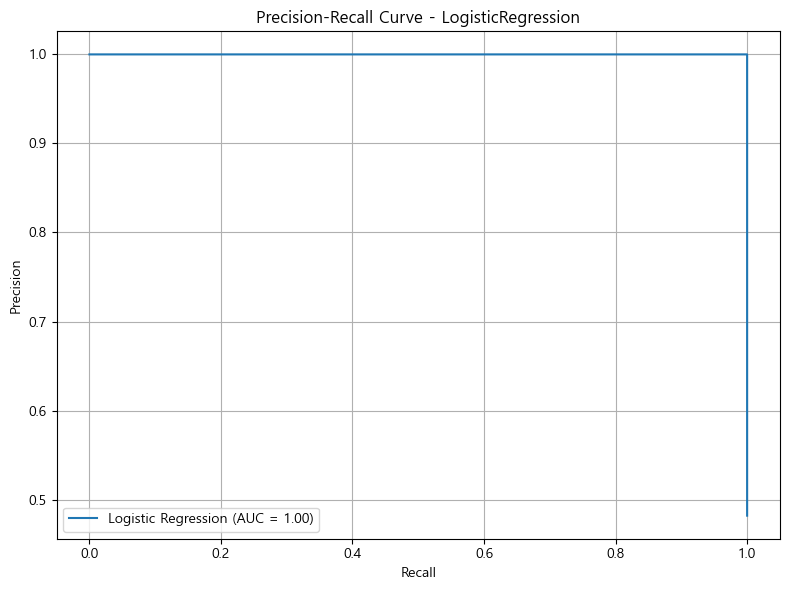

In [126]:
# Precision-Recall Curve 시각화
plt.figure(figsize=(8, 6))

# LogisticRegression
plt.plot(lr_recall, lr_precision, label=f"Logistic Regression (AUC = {lr_prc_auc:.2f})")

plt.title('Precision-Recall Curve - LogisticRegression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [127]:
preprocessor_temp = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'), ['odor', 'spore_print_color'])
    ]
)
print(X.columns.tolist())

['cap_shape', 'cap_surface', 'cap_color', 'bruises', 'odor', 'gill_attachment', 'gill_spacing', 'gill_size', 'gill_color', 'stalkshape', 'stalk_root', 'stalk_surface_above_ring', 'stalk_surface_below_ring', 'stalk_color_above_ring', 'stalk_color_below_ring', 'veil_type', 'veil_color', 'ring_number', 'ring_type', 'spore_print_color', 'population', 'habitat']


odor, spore_print_color 컬럼으로만 분류하여 시도해 보았습니다. 

In [128]:
X_temp = X[['odor', 'spore_print_color']]
X_temp_processed = preprocessor_temp.fit_transform(X_temp)

X_train, X_test, y_train, y_test = train_test_split(
    X_temp_processed, y, test_size=0.3, random_state=42, stratify=y
)

RandomForestClassifier로 두 컬럼을 예측하여 정확도를 확인합니다. 

In [129]:
rf_model_temp = RandomForestClassifier(random_state=42)
rf_model_temp.fit(X_train, y_train)

y_train_pred = rf_model_temp.predict(X_train)
y_test_pred = rf_model_temp.predict(X_test)

print("Train Set 성능 (RandomForestClassifier)")
print(f"- Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(classification_report(y_train, y_train_pred))

print("\nTest Set 성능 (RandomForestClassifier)")
print(f"- Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(classification_report(y_test, y_test_pred))

Train Set 성능 (RandomForestClassifier)
- Accuracy: 0.9942
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2945
           1       1.00      0.99      0.99      2741

    accuracy                           0.99      5686
   macro avg       0.99      0.99      0.99      5686
weighted avg       0.99      0.99      0.99      5686


Test Set 성능 (RandomForestClassifier)
- Accuracy: 0.9938
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1263
           1       1.00      0.99      0.99      1175

    accuracy                           0.99      2438
   macro avg       0.99      0.99      0.99      2438
weighted avg       0.99      0.99      0.99      2438



LogisticRegression로 두 컬럼을 예측하여 정확도를 확인합니다. 

In [130]:
# 1. 모델 정의 및 학습
lr_model_temp = LogisticRegression(max_iter=1000, random_state=42)
lr_model_temp.fit(X_train, y_train)

# 2. 예측
y_train_pred_lr = lr_model_temp.predict(X_train)
y_test_pred_lr = lr_model_temp.predict(X_test)

# 3. 성능 출력
print("Train Set 성능 (Logistic Regression)")
print(f"- Accuracy: {accuracy_score(y_train, y_train_pred_lr):.4f}")
print(classification_report(y_train, y_train_pred_lr))

print("\nTest Set 성능 (Logistic Regression)")
print(f"- Accuracy: {accuracy_score(y_test, y_test_pred_lr):.4f}")
print(classification_report(y_test, y_test_pred_lr))

Train Set 성능 (Logistic Regression)
- Accuracy: 0.9942
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2945
           1       1.00      0.99      0.99      2741

    accuracy                           0.99      5686
   macro avg       0.99      0.99      0.99      5686
weighted avg       0.99      0.99      0.99      5686


Test Set 성능 (Logistic Regression)
- Accuracy: 0.9938
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1263
           1       1.00      0.99      0.99      1175

    accuracy                           0.99      2438
   macro avg       0.99      0.99      0.99      2438
weighted avg       0.99      0.99      0.99      2438



예시를 들었을 경우에도 두 모델은 정확도가 같게 나와 어느 모델이 더 정확도가 높은지 비교할 수 없습니다. 

## **6) 하이퍼파라미터 튜닝**
---
본 데이터셋의 예측 정확도는 100%가 나와 하이퍼파라미터 튜닝을 하지 않고, 'odor', 'spore_print_color' 두 컬럼으로만 정확도 예측한 결과를 가지고 하이퍼파라미터 튜닝을 진행하였습니다. 
- GridSearchCV 또는 RandomizedSearchCV 사용합니다.
- 최적의 모델 파라미터 찾고 성능 향상 확인합니다. 

In [131]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

GridSearchCV 하이퍼파라미터 튜닝을 수행하였고 최적의 조합을 찾은 후 모델 성능을 평가하였습니다. 

In [ ]:
from sklearn.model_selection import GridSearchCV

# Grid Search
grid_search = GridSearchCV(
    estimator=rf_model_temp,
    param_grid=param_grid,
    cv=5,  # 5-Fold 교차검증
    scoring='accuracy',  # 정확도 기준
    n_jobs=-1,  # 모든 CPU 사용
    verbose=2  # 진행상황 출력
)

'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100 위 같은 최적 파라미터를 넣었을 때, 정확도가 가장 높게 나타났습니다. 

In [ ]:
# 실행 (Grid or Random 중 선택)
grid_search.fit(X_train, y_train)

# 최적 파라미터 확인
print("최적 파라미터:", grid_search.best_params_)
# 최적 모델로 예측 및 평가
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
최적 파라미터: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1263
           1       1.00      0.99      0.99      1175

    accuracy                           0.99      2438
   macro avg       0.99      0.99      0.99      2438
weighted avg       0.99      0.99      0.99      2438



LogisticResgression 모델을 하이퍼파라미터 튜닝 수행하여 최적화를 진행하였습니다. 

In [139]:
# 튜닝할 파라미터 설정 (LogisticRegression용)
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],             # 규제 강도 (inverse of regularization strength)
    'penalty': ['l2'],                         # 보통 L2 규제 사용
    'solver': ['lbfgs', 'saga'],                # 최적화 알고리즘 (multiclass 가능)
    'max_iter': [100, 500, 1000]                # 반복 횟수
}

In [140]:
# Grid Search
grid_search = GridSearchCV(
    estimator=lr_model_temp,
    param_grid=param_grid,
    cv=5,                 # 5-Fold 교차검증
    scoring='accuracy',    # 정확도 기준
    n_jobs=-1,             # CPU 모두 사용
    verbose=2              # 진행상황 출력
)

최적의 파라미터는 아래와 같습니다. 

In [141]:
# 실행
grid_search.fit(X_train, y_train)

# 최적 파라미터 확인
print("최적 파라미터:", grid_search.best_params_)

# 최적 모델로 예측 및 평가
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
최적 파라미터: {'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1263
           1       1.00      0.99      0.99      1175

    accuracy                           0.99      2438
   macro avg       0.99      0.99      0.99      2438
weighted avg       0.99      0.99      0.99      2438

